# Classify Cluster Stars Using Labels from Multiple Users

## Import Data

In [319]:
import numpy as np

cluster_id = 168
obs_count = 10

# Load the data
astrometry_list = []
label_list = []
for i in range(obs_count):
    astrometry_list.append(np.load('data/{}/{}-feature.npy'.format(cluster_id, i), allow_pickle=True))
    label_list.append(np.load('data/{}/{}-label.npy'.format(cluster_id, i), allow_pickle=True))

print(len(astrometry_list), astrometry_list[0].shape)
print(len(label_list), label_list[0].shape)

10 (392, 4)
10 (392,)


## Preview Data & Label

Make sure there's no garbage label

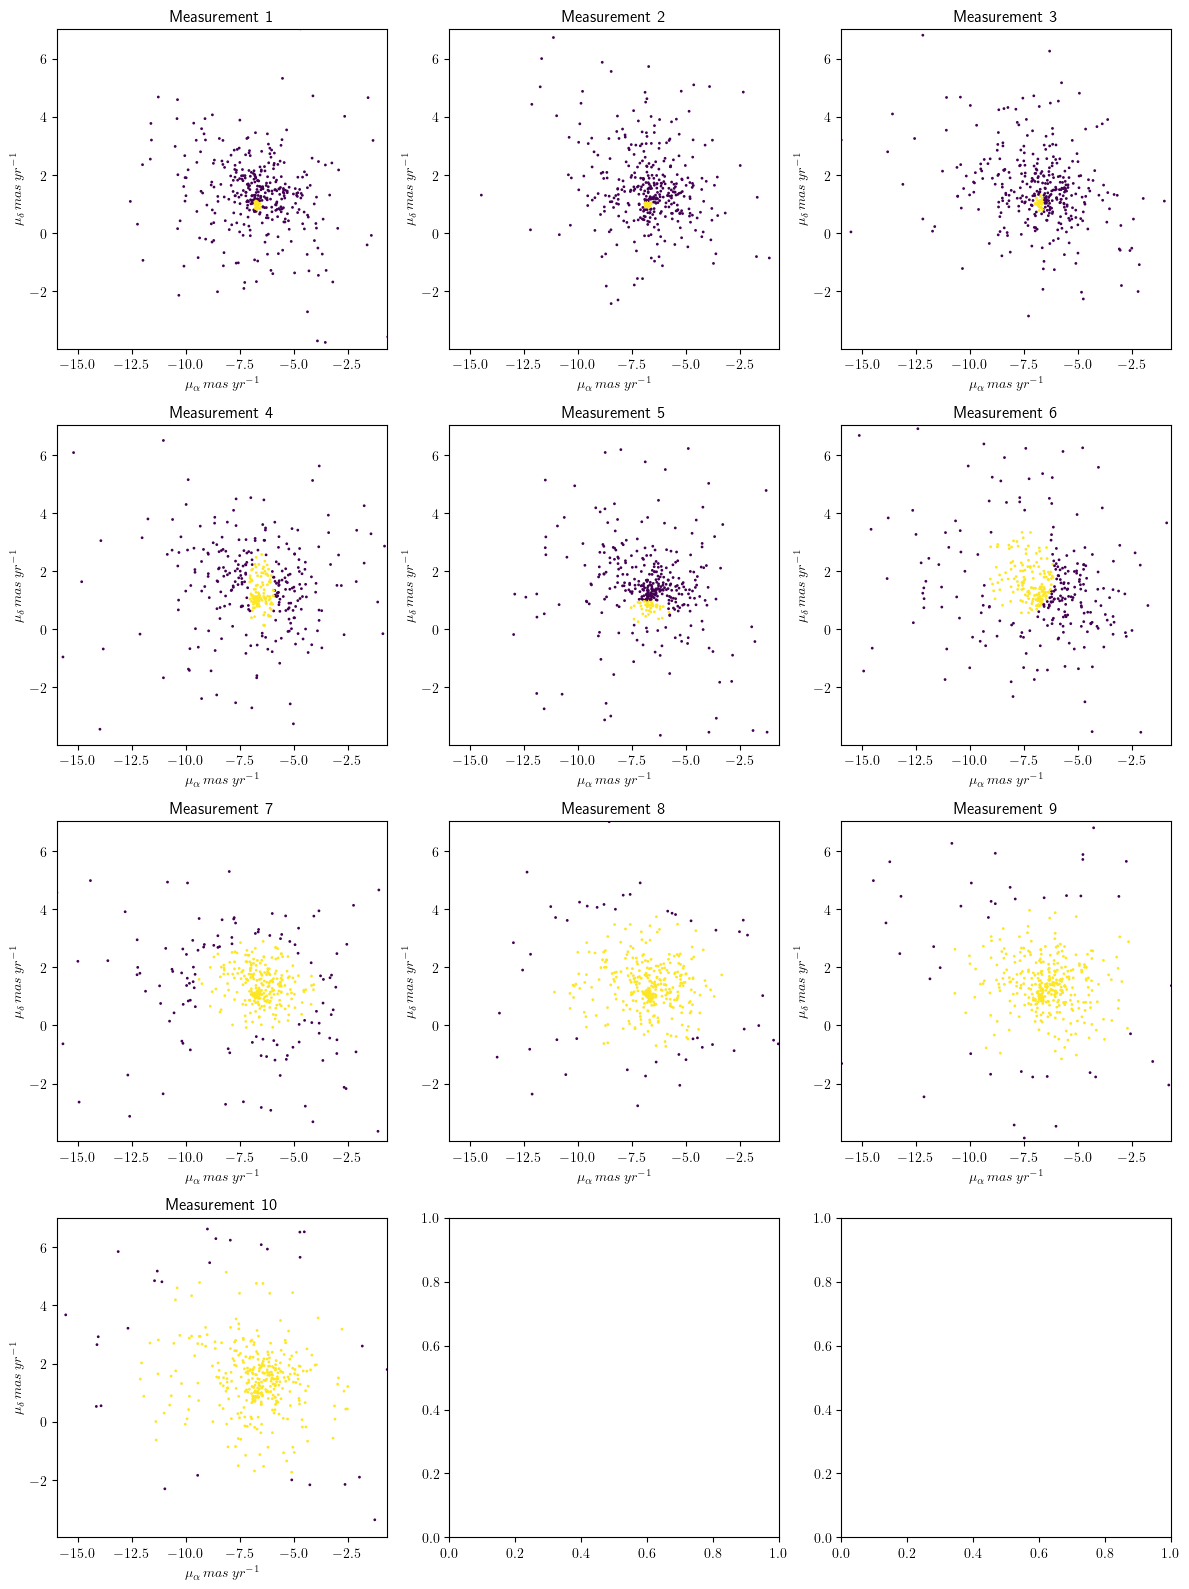

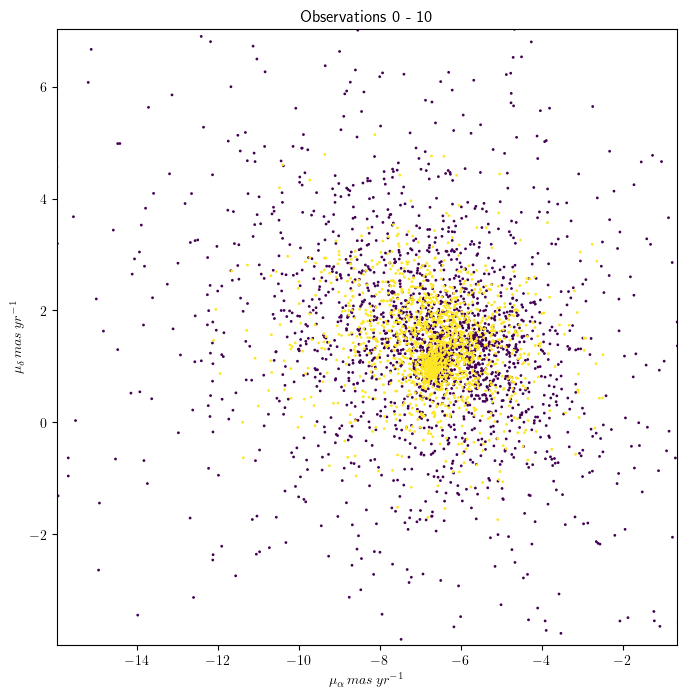

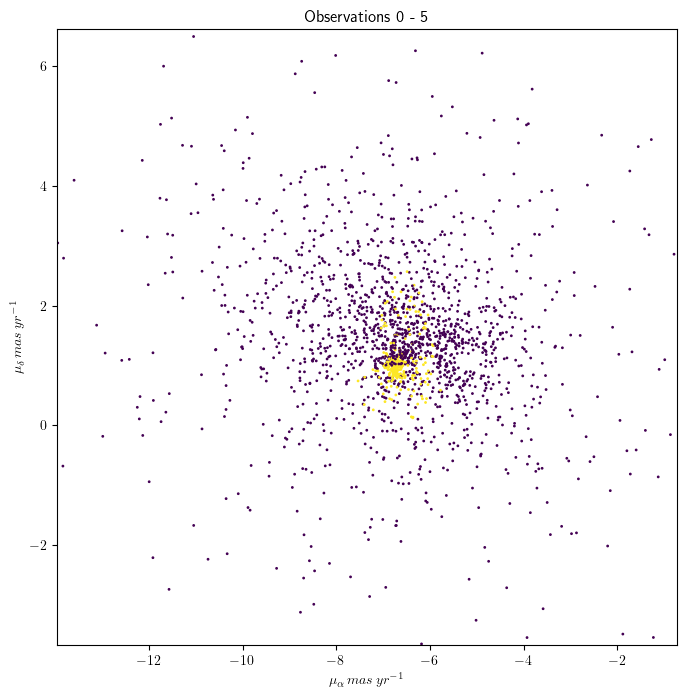

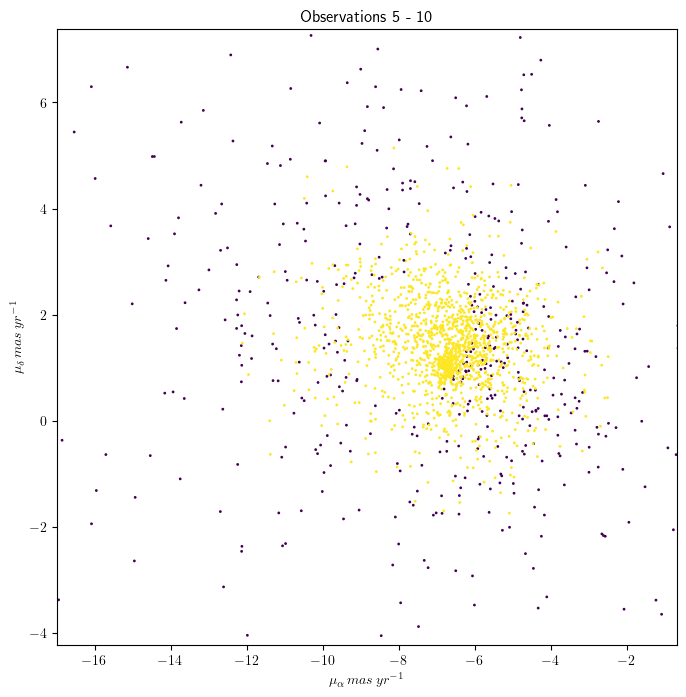

In [320]:
import matplotlib.pyplot as plt
import math


def plot_pm_grid(_features, _labels, columns=3):
    plt.rcParams['text.usetex'] = True
    rows = math.ceil(len(_features) / columns)
    fig, axs = plt.subplots(rows, columns, figsize=(columns * 4, rows * 4))

    # calculate framing
    _astrometry = np.concatenate(_features)
    _rf = 1
    _pm_ra_min = np.percentile(_astrometry[:, 2], _rf)
    _pm_ra_max = np.percentile(_astrometry[:, 2], 100 - _rf)
    _pm_dec_min = np.percentile(_astrometry[:, 3], _rf)
    _pm_dec_max = np.percentile(_astrometry[:, 3], 100 - _rf)

    for i in range(len(_features)):
        ax = axs[i // columns, i % columns]
        ax.scatter(_features[i][:, 2], _features[i][:, 3], c=_labels[i], s=1)
        ax.set_title('Measurement {}'.format(i + 1))
        ax.set_xlabel(r'$\mu_{\alpha}\,mas\,yr^{-1}$')
        ax.set_ylabel(r'$\mu_{\delta}\,mas\,yr^{-1}$')
        ax.set(xlim=(_pm_ra_min, _pm_ra_max), ylim=(_pm_dec_min, _pm_dec_max))

    plt.tight_layout()
    plt.show()


def plot_pm_all(_features, _labels, _rf, start=0, end=None):
    if end is None:
        end = len(_features)

    _features = _features[start:end]
    _labels = _labels[start:end]

    all_labels = []
    for label in _labels:
        all_labels += list(label)
    all_labels = np.array(all_labels)

    # calculate framing
    _astrometry = np.concatenate(_features)
    _rf = 1
    _pm_ra_min = np.percentile(_astrometry[:, 2], _rf)
    _pm_ra_max = np.percentile(_astrometry[:, 2], 100 - _rf)
    _pm_dec_min = np.percentile(_astrometry[:, 3], _rf)
    _pm_dec_max = np.percentile(_astrometry[:, 3], 100 - _rf)

    plt.figure(figsize=(8, 8))
    plt.scatter(_astrometry[:, 2], _astrometry[:, 3], c=all_labels, s=1)
    plt.title('Observations {} - {}'.format(start, end))
    plt.rcParams['text.usetex'] = True
    plt.xlabel(r'$\mu_{\alpha}\,mas\,yr^{-1}$')
    plt.ylabel(r'$\mu_{\delta}\,mas\,yr^{-1}$')
    ax = plt.gca()
    ax.set(xlim=(_pm_ra_min, _pm_ra_max), ylim=(_pm_dec_min, _pm_dec_max))


plot_pm_grid(astrometry_list, label_list)
plot_pm_all(astrometry_list, label_list, 1)
plot_pm_all(astrometry_list, label_list, 1, end=5)
plot_pm_all(astrometry_list, label_list, 1, start=5)


Turns out label 1-16 are pretty good, and 17-73 are garbage.

## Data Preprocessing
* Split data into training and testing set
* Standardize data (perhaps)

In [321]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# Split data
X_train = []
y_train = []
X_test = []
y_test = []
for i in range(obs_count):
    _features = astrometry_list[i][:, 2:4]
    _labels = label_list[i]
    _X_train, _X_test, _y_train, _y_test = train_test_split(_features, _labels, test_size=0.4, random_state=69)
    X_train.append(_X_train)
    y_train.append(_y_train)
    X_test.append(_X_test)
    y_test.append(_y_test)
    print('Obs {}: {} -> {} / {} -> {}'.format(i, _features.shape, _X_train.shape, _labels.shape, _y_train.shape))

# Standardize data
astrometry = np.concatenate(astrometry_list)[:, 2:4]
scaler = preprocessing.StandardScaler().fit(astrometry)

for i in range(obs_count):
    X_train[i] = scaler.transform(X_train[i])
    X_test[i] = scaler.transform(X_test[i])


Obs 0: (392, 2) -> (235, 2) / (392,) -> (235,)
Obs 1: (392, 2) -> (235, 2) / (392,) -> (235,)
Obs 2: (392, 2) -> (235, 2) / (392,) -> (235,)
Obs 3: (392, 2) -> (235, 2) / (392,) -> (235,)
Obs 4: (392, 2) -> (235, 2) / (392,) -> (235,)
Obs 5: (391, 2) -> (234, 2) / (391,) -> (234,)
Obs 6: (391, 2) -> (234, 2) / (391,) -> (234,)
Obs 7: (391, 2) -> (234, 2) / (391,) -> (234,)
Obs 8: (391, 2) -> (234, 2) / (391,) -> (234,)
Obs 9: (391, 2) -> (234, 2) / (391,) -> (234,)


## Train Model

In [322]:
from sklearn import svm

# for nu in np.arange(0.01, 0.18, 0.01):
models = []
# accuracy = []
# precision = []
# recall = []
for i in range(obs_count):
    _model = svm.NuSVC(kernel='rbf', cache_size=2048, nu=0.07, gamma="auto")
    _model.fit(X_train[i], y_train[i])
    _accuracy = _model.score(X_test[i], y_test[i])
    _precision = _model.score(X_test[i][y_test[i] == 1], y_test[i][y_test[i] == 1])
    _recall = _model.score(X_test[i][y_test[i] == 0], y_test[i][y_test[i] == 0])
    models.append(_model)
    #         accuracy.append(_accuracy)
    #         precision.append(_precision)
    #         recall.append(_recall)
    print('Obs {}: {:.2f}% (Precision: {:.2f}%, Recall: {:.2f}%)'.format(i, _accuracy * 100, _precision * 100,
                                                                         _recall * 100))
    # print('Nu: {:.2f}; Obs {}: {:.2f}% (Precision: {:.2f}%, Recall: {:.2f}%)'.format(nu, i+1, _accuracy * 100, _precision * 100, _recall * 100))
    # print('Obs {}: {:.2f}%'.format(i, _model.score(X_test[i], y_test[i]) * 100))

    # print('Nu: {:.2f}'.format(nu))
    # print('Average Accuracy: {:.2f}%'.format(np.mean(accuracy) * 100))
    # print('Average Precision: {:.2f}%'.format(np.mean(precision) * 100))
    # print('Average Recall: {:.2f}%'.format(np.mean(recall) * 100))
    # print("{:.2f} & {:.2f} & {:.2f} & {:.2f} \\\\".format(nu, np.mean(accuracy) * 100, np.mean(precision) * 100, np.mean(recall) * 100))


Obs 0: 94.90% (Precision: 100.00%, Recall: 94.44%)
Obs 1: 99.36% (Precision: 100.00%, Recall: 99.33%)
Obs 2: 96.18% (Precision: 91.67%, Recall: 96.55%)
Obs 3: 98.09% (Precision: 97.87%, Recall: 98.18%)
Obs 4: 98.73% (Precision: 100.00%, Recall: 98.56%)
Obs 5: 98.09% (Precision: 100.00%, Recall: 96.81%)
Obs 6: 98.73% (Precision: 97.98%, Recall: 100.00%)
Obs 7: 99.36% (Precision: 100.00%, Recall: 96.00%)
Obs 8: 98.09% (Precision: 100.00%, Recall: 85.00%)
Obs 9: 98.73% (Precision: 100.00%, Recall: 90.00%)


## Visualize Decision Boundary

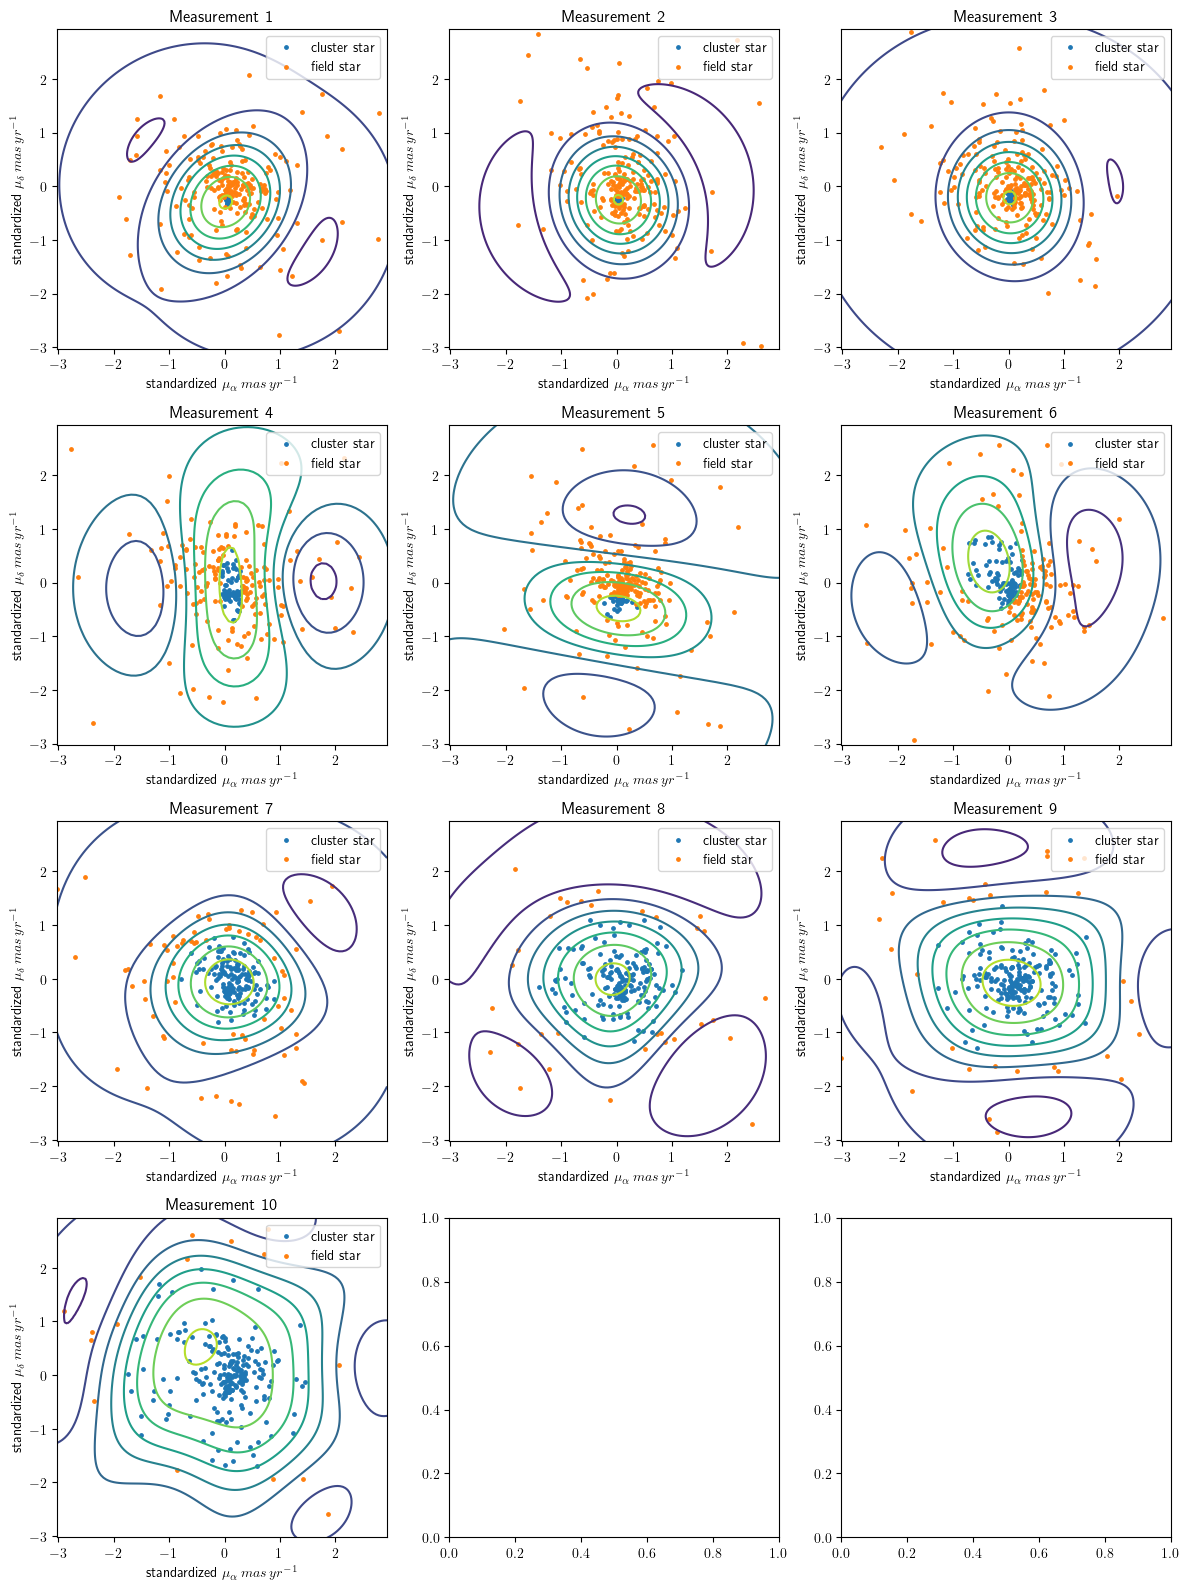

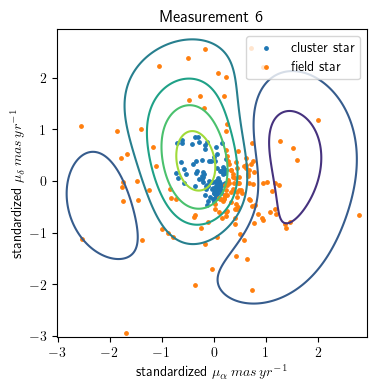

In [323]:
from sklearn.inspection import DecisionBoundaryDisplay


def plot_pm_grid_trained(_features, _labels, _models, columns=3):
    rows = math.ceil(len(_features) / columns)
    fig, axs = plt.subplots(rows, columns, figsize=(columns * 4, rows * 4))

    # calculate framing
    _astrometry = np.concatenate(_features)
    _rf = 1
    _pm_ra_min = np.percentile(_astrometry[:, 0], _rf)
    _pm_ra_max = np.percentile(_astrometry[:, 1], 100 - _rf)
    _pm_dec_min = np.percentile(_astrometry[:, 0], _rf)
    _pm_dec_max = np.percentile(_astrometry[:, 1], 100 - _rf)

    plt.rcParams['text.usetex'] = True
    for i in range(len(_features)):
        ax = axs[i // columns, i % columns]
        # ax.scatter(_features[i][:, 0], _features[i][:, 1], c=_labels[i], s=1)
        ax.scatter(_features[i][:, 0][_labels[i] == 1], _features[i][:, 1][_labels[i] == 1], s=6)
        ax.scatter(_features[i][:, 0][_labels[i] == 0], _features[i][:, 1][_labels[i] == 0], s=6)
        ax.set_title('Measurement {}'.format(i + 1))
        ax.set_xlabel(r'standardized $\mu_{\alpha}\,mas\,yr^{-1}$')
        ax.set_ylabel(r'standardized $\mu_{\delta}\,mas\,yr^{-1}$')
        ax.legend(['cluster star', 'field star'], loc='upper right')
        ax.set(xlim=(_pm_ra_min, _pm_ra_max), ylim=(_pm_dec_min, _pm_dec_max))
        DecisionBoundaryDisplay.from_estimator(_models[i], X=_features[i], ax=ax, plot_method="contour",
                                               grid_resolution=300)

    plt.tight_layout()
    plt.show()


def plot_pm_trained_one(_features, _labels, _models, _i):
    # calculate framing
    _astrometry = np.concatenate(_features)
    _rf = 1
    _pm_ra_min = np.percentile(_astrometry[:, 0], _rf)
    _pm_ra_max = np.percentile(_astrometry[:, 1], 100 - _rf)
    _pm_dec_min = np.percentile(_astrometry[:, 0], _rf)
    _pm_dec_max = np.percentile(_astrometry[:, 1], 100 - _rf)

    plt.rcParams['text.usetex'] = True
    plt.figure(figsize=(4, 4))
    plt.scatter(_features[_i][:, 0][_labels[_i] == 1], _features[_i][:, 1][_labels[_i] == 1], s=6)
    plt.scatter(_features[_i][:, 0][_labels[_i] == 0], _features[_i][:, 1][_labels[_i] == 0], s=6)
    plt.title('Measurement {}'.format(_i + 1))
    plt.xlabel(r'standardized $\mu_{\alpha}\,mas\,yr^{-1}$')
    plt.ylabel(r'standardized $\mu_{\delta}\,mas\,yr^{-1}$')
    plt.legend(['cluster star', 'field star'], loc='upper right')
    ax = plt.gca()
    DecisionBoundaryDisplay.from_estimator(_models[_i], X=_features[_i], ax=ax, plot_method="contour",
                                           grid_resolution=1000)
    ax.set(xlim=(_pm_ra_min, _pm_ra_max), ylim=(_pm_dec_min, _pm_dec_max))
    plt.show()


plot_pm_grid_trained(X_train, y_train, models)

plot_pm_trained_one(X_train, y_train, models, 5)

In [371]:
scores = []
precisions = []
recalls = []
for i in range(obs_count):
    _score = models[i].score(X_test[i], y_test[i])
    _precision = models[i].score(X_test[i][y_test[i] == 1], y_test[i][y_test[i] == 1])
    _recall = models[i].score(X_test[i][y_test[i] == 0], y_test[i][y_test[i] == 0])
    scores.append(_score)
    precisions.append(_precision)
    recalls.append(_recall)
    print('{} & {:.2f} & {:.2f} & {:.2f} \\\\'.format(i + 1, _score * 100, _precision * 100, _recall * 100))
scores = np.array(scores) * 100
precisions = np.array(precisions) * 100
recalls = np.array(recalls) * 100

1 & 94.90 & 100.00 & 94.44 \\
2 & 99.36 & 100.00 & 99.33 \\
3 & 96.18 & 91.67 & 96.55 \\
4 & 98.09 & 97.87 & 98.18 \\
5 & 98.73 & 100.00 & 98.56 \\
6 & 98.09 & 100.00 & 96.81 \\
7 & 98.73 & 97.98 & 100.00 \\
8 & 99.36 & 100.00 & 96.00 \\
9 & 98.09 & 100.00 & 85.00 \\
10 & 98.73 & 100.00 & 90.00 \\


## Cross Evaluation
Calculate the accuracy of each model using other observations as testing set

In [370]:
pm_ranges = np.load('data/{}/obs.npy'.format(cluster_id))
plot_ranges = np.array(
    [abs(pm_range[0][0] - pm_range[0][1]) + abs(pm_range[1][0] - pm_range[1][1]) for pm_range in pm_ranges])

scores = []
precisions = []
recalls = []
valid_obs = range(obs_count)
# valid_obs = np.where(plot_ranges < 5)[0]
for i in valid_obs:
    # _test_obs = np.random.randint(0, obs_count, obs_count//4)
    _test_obs = valid_obs
    _X_test = np.stack([X_test[j] for j in _test_obs if j != i]).reshape(-1, 2)
    _y_test = np.concatenate([y_test[j] for j in _test_obs if j != i])
    _model = models[i]
    _score = _model.score(_X_test, _y_test)
    _precision = _model.score(_X_test[_y_test == 1], _y_test[_y_test == 1])
    _recall = _model.score(_X_test[_y_test == 0], _y_test[_y_test == 0])
    _f1 = 2 * _precision * _recall / (_precision + _recall)
    # print('Obs {}: {:.2f}%'.format(i, _score * 100))
    scores.append(_score)
    precisions.append(_precision)
    recalls.append(_recall)
    print('{} & {:.2f} & {:.2f} & {:.2f} & {:.2f} \\\\'.format(i + 1, _score * 100, _precision * 100, _recall * 100 , _f1*100))

scores = np.array(scores) * 100
precisions = np.array(precisions) * 100
recalls = np.array(recalls) * 100

best_model = int(np.argsort(scores)[-1])
# print('Best Model: Obs {index} with score {score:2f}'.format(index=best_model+1, score=scores[best_model]))

1 & 60.58 & 15.62 & 99.21 & 26.99 \\
2 & 59.31 & 13.83 & 98.94 & 24.27 \\
3 & 59.38 & 16.51 & 96.31 & 28.19 \\
4 & 63.20 & 43.30 & 78.72 & 55.86 \\
5 & 58.53 & 16.82 & 93.86 & 28.53 \\
6 & 59.87 & 54.89 & 63.58 & 58.92 \\
7 & 59.87 & 85.89 & 42.43 & 56.80 \\
8 & 52.80 & 96.82 & 26.05 & 41.06 \\
9 & 50.81 & 99.24 & 21.83 & 35.79 \\
10 & 44.66 & 100.00 & 11.54 & 20.69 \\


## Plot PM range vs. Accuracy

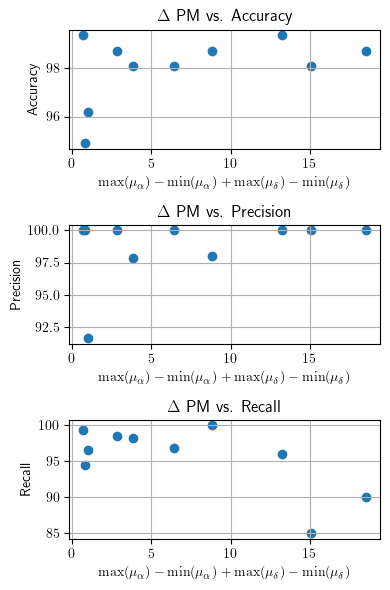

In [373]:

fig, axs = plt.subplots(3, 1, figsize=(4, 6))
plt.rcParams['text.usetex'] = True

axs[0].scatter(plot_ranges, scores)
axs[0].set_title(r'$\Delta$ PM vs. Accuracy')
axs[0].set_xlabel(r'$\max(\mu_\alpha) - \min(\mu_\alpha) + \max(\mu_\delta) - \min(\mu_\delta)$')
axs[0].set_ylabel('Accuracy%')
axs[0].grid()

axs[1].scatter(plot_ranges, precisions)
axs[1].set_title(r'$\Delta$ PM vs. Precision')
axs[1].set_xlabel(r'$\max(\mu_\alpha) - \min(\mu_\alpha) + \max(\mu_\delta) - \min(\mu_\delta)$')
axs[1].set_ylabel('Precision%')
axs[1].grid()

axs[2].scatter(plot_ranges, recalls)
axs[2].set_title(r'$\Delta$ PM vs. Recall')
axs[2].set_xlabel(r'$\max(\mu_\alpha) - \min(\mu_\alpha) + \max(\mu_\delta) - \min(\mu_\delta)$')
axs[2].set_ylabel('Recall%')
axs[2].grid()

plt.tight_layout()
plt.show()


## Voting!

In [369]:
def ensemble_accuracy(_X_test_list, _y_test_list, _ensemble):
    _X = np.stack(_X_test_list).reshape(-1, 2)
    _y = np.concatenate(_y_test_list)
    _votes = np.zeros(len(_y))
    for _model in _ensemble:
        _votes += _model.predict(_X)
    _vote_accuracy = np.sum(_votes == _y) / len(_y)
    _vote_precision = np.sum((_votes == _y) & (_y == 1)) / np.sum(_y == 1)
    _vote_recall = np.sum((_votes == _y) & (_y == 0)) / np.sum(_y == 0)
    _vote_f1 = 2 * _vote_precision * _vote_recall / (_vote_precision + _vote_recall)
    return _vote_accuracy, _vote_precision, _vote_recall, _vote_f1


for i in [3, 5]:
    ensemble_size = i
    top_models = np.argsort(recalls + precisions)[-ensemble_size:]
    ensemble = [models[i] for i in top_models]
    vote_accuracy, vote_precision, vote_recall, vote_f1 = ensemble_accuracy(X_test[:5], y_test[:5], ensemble)
    print('{} & {:.2f} & {:.2f} & {:.2f} & {:.2f} \\\\'.format(ensemble_size, vote_accuracy * 100, vote_precision * 100,
                                                      vote_recall * 100, vote_f1 * 100))


3 & 71.59 & 41.84 & 75.84 & 53.92 \\
5 & 67.26 & 27.55 & 72.93 & 39.99 \\


## Plot Results

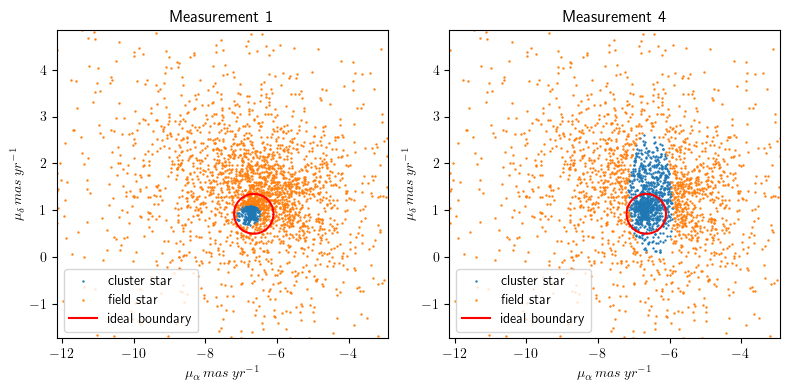

In [359]:
X_all = np.load('data/{}/raw.npy'.format(cluster_id), allow_pickle=True)

rf = 3
pm_ra_min = np.percentile(X_all[:, 2], rf)
pm_ra_max = np.percentile(X_all[:, 2], 100 - rf)
pm_dec_min = np.percentile(X_all[:, 3], rf)
pm_dec_max = np.percentile(X_all[:, 3], 100 - rf)


def get_pm_boundary(_min_pmra, _max_pmra, _min_pmdec, _max_pmdec):
    segments = 80
    bndry_x = []
    bndry_y = []

    bndry_delta = 2 * math.pi / segments
    a = (_max_pmra - _min_pmra) / 2
    b = (_max_pmdec - _min_pmdec) / 2
    center_pmra = (_max_pmra + _min_pmra) / 2
    center_pmdec = (_max_pmdec + _min_pmdec) / 2
    for i in range(segments):
        theta = i * bndry_delta
        bndry_x.append(a * math.cos(theta) + center_pmra)
        bndry_y.append(b * math.sin(theta) + center_pmdec)
    return [bndry_x, bndry_y]


bdry = get_pm_boundary(-7.2, -6.1, 0.5, 1.35)
plt.rcParams['text.usetex'] = True
valid_obs = [0, 3]
fig, axs = plt.subplots(1, len(valid_obs), figsize=(4 * len(valid_obs), 4))
for i in range(len(valid_obs)):
    _ax = axs[i]
    _model = models[valid_obs[i]]
    _y = _model.predict(scaler.transform(X_all[:, 2:4]))
    _ax.scatter(X_all[:, 2][_y == 1], X_all[:, 3][_y == 1], s=0.5)
    _ax.scatter(X_all[:, 2][_y == 0], X_all[:, 3][_y == 0], s=0.5)
    _ax.plot(bdry[0], bdry[1], 'r')
    _ax.set_title('Measurement {}'.format(valid_obs[i] + 1))
    _ax.set_xlabel(r'$\mu_{\alpha}\,mas\,yr^{-1}$')
    _ax.set_ylabel(r'$\mu_{\delta}\,mas\,yr^{-1}$')
    _ax.legend(['cluster star', 'field star', 'ideal boundary'], loc='lower left')
    _ax.set(xlim=(pm_ra_min, pm_ra_max), ylim=(pm_dec_min, pm_dec_max))

plt.tight_layout()
plt.show()
